In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
from tensorflow.keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.applications import VGG19
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, LeakyReLU
from keras.layers import Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils import plot_model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("No GPU devices found. Make sure your GPU is properly installed and configured.")
else:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured successfully.")

GPU configured successfully.


In [3]:
import tensorflow as tf

# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate GPU memory growth
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU memory growth set to True")
    except RuntimeError as e:
        print(e)

GPU memory growth set to True


In [4]:
import tensorflow as tf

# Check if TensorFlow can access GPU
num_gpus = len(tf.config.experimental.list_physical_devices('GPU'))

if num_gpus > 0:
    print("Num GPUs Available: ", num_gpus)
    print("TensorFlow is using GPU.")
else:
    print("No GPU available. TensorFlow is using CPU.")

Num GPUs Available:  1
TensorFlow is using GPU.


In [5]:
import tarfile

#simple function to extract the train data
#tar_file : the path to the .tar file
#path : the path where it will be extracted
def extract(tar_file, path):
    opened_tar = tarfile.open(tar_file)
     
    if tarfile.is_tarfile(tar_file):
        opened_tar.extractall(path)
    else:
        print("The tar file you entered is not a tar file")

In [6]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image,tf.float32)
    return image

In [7]:
path = "/kaggle/input/imagenet/imagenet"
x = load(os.path.join(path, 'train/ILSVRC2012_val_00005001.JPEG'))
print(x.shape)

(500, 333, 3)


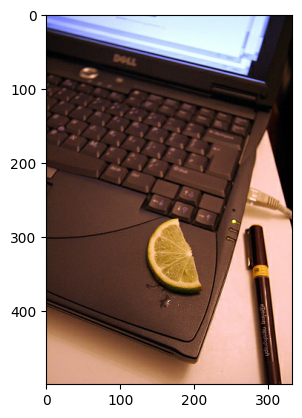

In [8]:
plt.imshow(x/255.0)

In [9]:
def normalize(real_image):
    real_image = (real_image / 255)
    return real_image

In [10]:
def random_crop(real_image):
    cropped_image = tf.image.random_crop(real_image, size = [256, 256, 3])
    return cropped_image

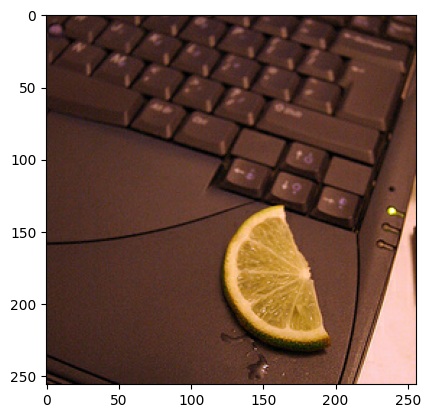

In [11]:
x_aug = random_crop(x)
plt.imshow(x_aug/255.0)

In [12]:
def resize(real_image):
    real_image = tf.image.resize(real_image, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return real_image
def resize_300(real_image):
    real_image = tf.image.resize(real_image, [300, 300], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return real_image

In [13]:
def rotate_image(image, angles, interpolation='BILINEAR'):
    """
    Rotate an image tensor by specified angles.

    Args:
    - image: Input image tensor with shape (batch_size, height, width, channels).
    - angles: Tensor of rotation angles in radians for each image in the batch.
    - interpolation: Interpolation method ('BILINEAR' or 'NEAREST').

    Returns:
    - Rotated image tensor.
    """
    batch_size, height, width, channels = tf.unstack(tf.shape(image))

    # Coordinates of the center of the image
    center_x = tf.cast(width, tf.float32) / 2.0
    center_y = tf.cast(height, tf.float32) / 2.0

    # Define transformation matrix
    rotation_matrix = tf.reshape(tf.stack([tf.cos(angles), -tf.sin(angles), center_x * (1 - tf.cos(angles)) + center_y * tf.sin(angles),
                                           tf.sin(angles), tf.cos(angles), -center_x * tf.sin(angles) + center_y * (1 - tf.cos(angles)),
                                           0.0, 0.0, 1.0], axis=1), shape=(-1, 3, 3))

    # Apply rotation to each pixel
    rotated_image = tfa.image.transform(image, rotation_matrix, interpolation)

    return rotated_image


In [14]:
def random_jitter(real_image):
    if tf.random.uniform(()) > 0.5:
        real_image = tf.image.flip_left_right(real_image)
    return real_image

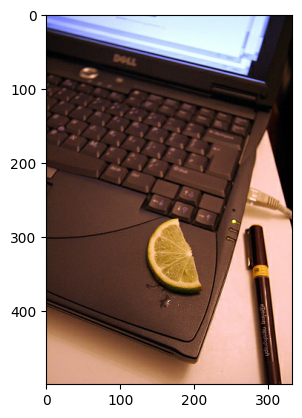

In [15]:
x_jitter = random_jitter(x)
plt.imshow(x_jitter/255.0)

In [16]:
def load_train_images(image_path):
    real_image = load(image_path)
    real_image = resize_300(real_image)
    real_image = tf.image.random_brightness(real_image, 0.2)
    real_image = random_crop(real_image)
    # Define the rotation angle in radians
    rotation_angle = tf.constant(20.0 * (3.141592653589793 / 180.0), dtype=tf.float32)

    # Apply the rotation using tfa.image.rotate
    real_image = tfa.image.rotate(real_image, angles=rotation_angle)

#     # Example usage
#     angles = tf.placeholder(dtype=tf.float32, shape=(None,))
#     # Specify the rotation range in degrees
#     rotation_range = 15  # Adjust this value as needed
#     # Convert the rotation range to radians
#     rotation_range_rad = rotation_range * (np.pi / 180.0)
#     # Generate random rotation angles for each image in the batch
#     random_angles = tf.random.uniform(shape=(tf.shape(image)[0],), minval=-rotation_range_rad, maxval=rotation_range_rad)
#     # Apply custom rotation to the image with bilinear interpolation
#     real_image = rotate_image(real_image, random_angles, interpolation='BILINEAR')
    #     real_image = rotate(real_image)
    real_image = random_jitter(real_image)
    real_image = normalize(real_image)
    yuv_image = tf.image.rgb_to_yuv(real_image)
    # Separate LAB into L and AB components
    Y_channel = tf.expand_dims(yuv_image[:, :, 0], axis=-1)  # L channel
    UV_channels = yuv_image[:, :, 1:]  # AB channels
    #here L_channel becomes input i.e light/luminance of pixel and AB_channels become target
    return Y_channel, UV_channels

In [17]:
def load_test_image(image_path):
    real_image = load(image_path)
    real_image = resize(real_image)
    real_image = normalize(real_image)
    yuv_image = tf.image.rgb_to_yuv(real_image)
    # Separate LAB into L and AB components
    Y_channel = tf.expand_dims(yuv_image[:, :, 0], axis=-1)  # L channel
    UV_channels = yuv_image[:, :, 1:]  # AB channels
    #here L_channel becomes input i.e light/luminance of pixel and AB_channels become target
    return Y_channel, UV_channels

In [18]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [19]:
# create input pipeline
train_dataset = tf.data.Dataset.list_files(path + "/train/*.JPEG")
train_dataset = train_dataset.map(load_train_images)
train_dataset = train_dataset.shuffle(10).batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>

In [20]:
validation_dataset = tf.data.Dataset.list_files(path + '/val/*.JPEG')
validation_dataset = validation_dataset.map(load_test_image)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
validation_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>

In [21]:
test_dataset = tf.data.Dataset.list_files(path + '/val/*.JPEG')
test_dataset = test_dataset.map(load_test_image)
test_dataset = test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>

In [22]:
# downsample block
def downsample(filters, size,dropout=False, batchnorm = True):
    init = tf.random_normal_initializer(0.,0.02)
    result = Sequential()
    result.add(Conv2D(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    if batchnorm == True:
        result.add(BatchNormalization())
    if dropout == True :
        result.add(Dropout(0.3))
    result.add(LeakyReLU())
    return result
down_model = downsample(3,4)
down_result = down_model(tf.expand_dims(x, axis = 0))
print(down_result.shape)

(1, 250, 167, 3)


In [23]:
# upsample block
def upsample(filters, size, dropout = False):
    init = tf.random_normal_initializer(0, 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    result.add(BatchNormalization())
    if dropout == True:
        result.add(Dropout(0.3))
    result.add(ReLU())
    return result
up_model = upsample(3,4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 500, 334, 3)


In [24]:
def generator(input_shape = (256,256,1), output_channels = 2):
    inputs = Input(shape = input_shape)
    down_stack = [
        downsample(64, 4, batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4, dropout = True),
        downsample(1024, 4, dropout = True)
    ]


    up_stack = [
        upsample(1024, 4, dropout=True),
        upsample(512, 4, dropout=True),
        upsample(256, 4, dropout=True),
        upsample(128, 4),
        upsample(64, 4),
    ]
    init = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(2, 4, strides = 2, padding = "same", kernel_initializer = init, activation ="tanh")
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)
    return Model(inputs = inputs, outputs = x)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 128, 128, 64)         1024      ['input_1[0][0]']             
                                                                                                  
 sequential_3 (Sequential)   (None, 64, 64, 128)          131584    ['sequential_2[0][0]']        
                                                                                                  
 sequential_4 (Sequential)   (None, 32, 32, 256)          525312    ['sequential_3[0][0]']        
                                                                                              

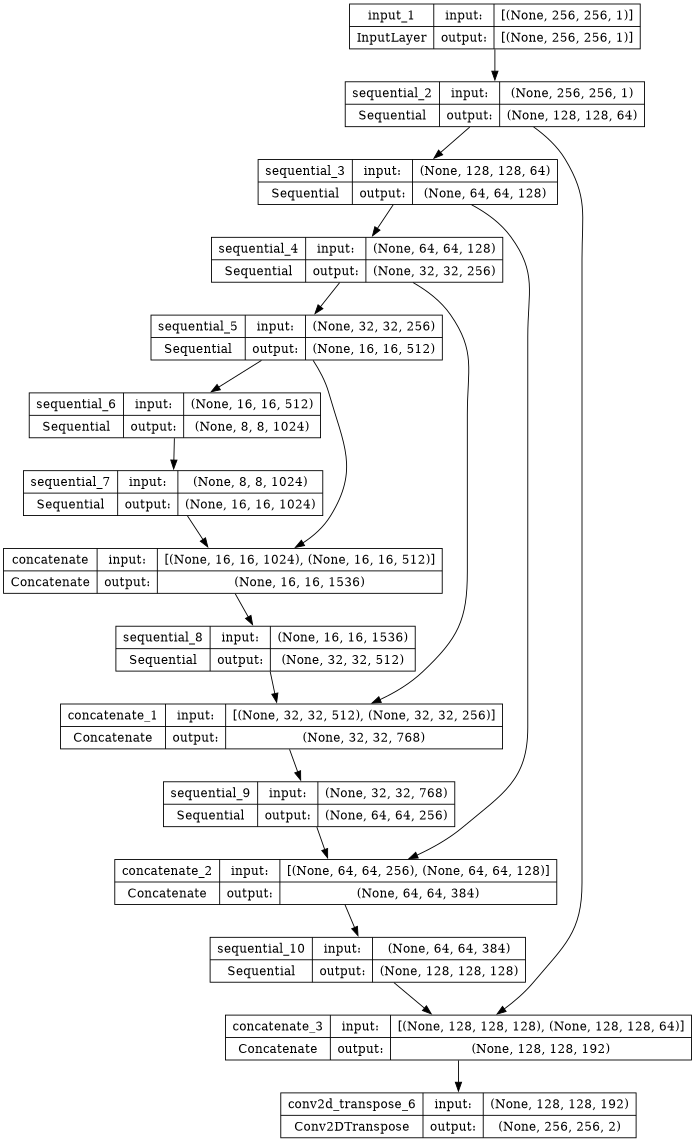

In [25]:
gen = generator()
gen.summary()
plot_model(gen, show_shapes=True, dpi = 64)

In [26]:
def discriminator():
    init = tf.random_normal_initializer(0., 0.02)

    inp = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 1], name = "input_image")
    tar = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 2], name = "target_image")
    x = Concatenate()([inp, tar])
    down1 = downsample(64,4,False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(256, 4, strides = 1, kernel_initializer = init, use_bias = False)(zero_pad1)
    leaky_relu = LeakyReLU()(conv)
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides = 1, kernel_initializer=init)(zero_pad2)
    return Model(inputs = [inp, tar], outputs = last)

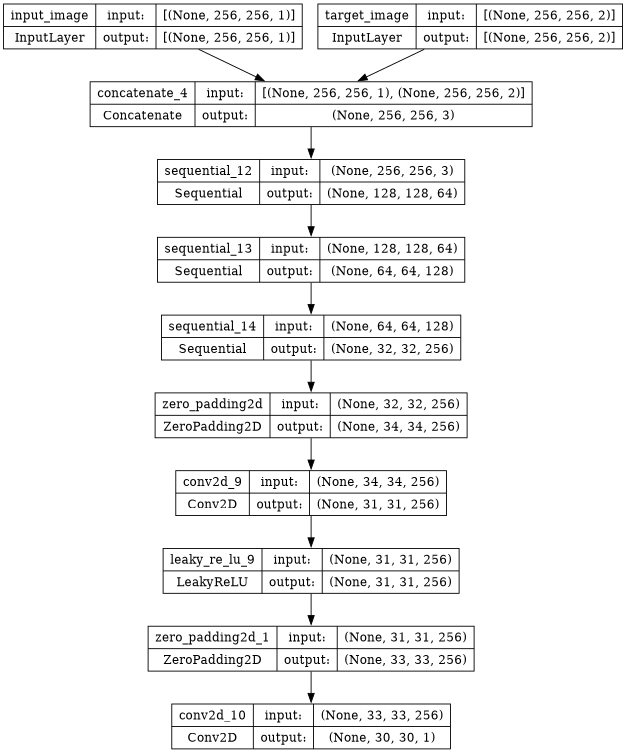

In [27]:
disc = discriminator()
plot_model(disc, show_shapes=True, dpi = 64)

In [28]:
# Function to create YUV image from Y, U, and V channels and then convert to rgb
def create_rgb_image(y_channel, uv_channel):
    # Assuming YUV format where Y, U, and V channels are separate
    # y_channel = np.array(y_channel)
    # uv_channel = np.array(uv_channel)
    u_channel, v_channel = tf.split(uv_channel, num_or_size_splits=2, axis=-1)

    # Combine Y, U, and V channels into a YUV image
    rgb_image = tf.image.yuv_to_rgb(tf.concat([y_channel, u_channel, v_channel], axis=-1))
    return rgb_image


In [29]:
LAMBDA = 140

In [30]:
# # Define the perceptual loss function
# def perceptual_loss(y_true, y_pred):
#     vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None, None, 3))
#     vgg.trainable = False
#     for layer in vgg.layers:
#         layer.trainable = False
#     model = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)
#     model.trainable = False

#     y_true_features = model(y_true)
#     y_pred_features = model(y_pred)

#     return tf.reduce_mean(tf.square(y_true_features - y_pred_features))

In [31]:
def generator_loss(disc_generated_output,input_, gen_output, target):
    gan_loss = loss_function(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
#     p_loss = perceptual_loss(create_rgb_image(input_, gen_output), create_rgb_image(input_, target))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss) 
    return total_gen_loss, gan_loss, l1_loss, 0

In [32]:
from keras.losses import BinaryCrossentropy
loss_function = BinaryCrossentropy(from_logits=True)

In [33]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_function(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_function(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss, real_loss, generated_loss

In [34]:
generator_optimizer = Adam(lr= 2e-4, beta_1=0.5)
discriminator_optimizer = Adam(lr = 2e-4, beta_1=0.5)

In [35]:
epochs = 250

In [36]:
# import tensorflow as tf
# from tensorflow.keras.applications import VGG19
# from tensorflow.keras.models import Model

# # Load the VGG19 model
# vgg = VGG19(weights='imagenet', include_top=False)

# # Select the layers you want to use for the LPIPS score
# selected_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1']

# # Create a model that outputs the selected layers
# outputs = [vgg.get_layer(name).output for name in selected_layers]
# model = Model(inputs=vgg.input, outputs=outputs)

# # Make sure the VGG model is not trainable
# model.trainable = False

# def lpips_score(image1, image2):
#     # Get the features for both images
#     image1_features = model(image1)
#     image2_features = model(image2)

#     # Initialize the score
#     score = 0

#     # For each feature layer...
#     for f1, f2 in zip(image1_features, image2_features):
#         # ... compute the mean squared error between the features
#         mse = tf.reduce_mean((f1 - f2)**2)
#         # ... and add it to the score
#         score += mse

#     return score

In [37]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from scipy.linalg import sqrtm

# # Load the pre-trained InceptionV3 model (weights will be downloaded if not present)
# pretrained_model = InceptionV3(weights='imagenet', include_top=True, pooling='avg')

# # Optionally, you can freeze the layers to prevent training
# for layer in pretrained_model.layers:
#     layer.trainable = False


# # Create a new model to extract features from an intermediate layer
# inception_model = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('avg_pool').input)
# def calculate_fid_score(images1, images2, inception_model):
#     # Ensure the batch dimension is removed for individual image predictions
#     images1 = np.squeeze(images1, axis=0)
#     images2 = np.squeeze(images2, axis=0)
    
#     # Resize images to the required size for the Inception model
#     images1 = tf.image.resize(images1, size=(299, 299))
#     images2 = tf.image.resize(images2, size=(299, 299))
    
#     # Extract features using the Inception model
#     features1 = inception_model.predict(np.expand_dims(images1, axis=0))
#     features2 = inception_model.predict(np.expand_dims(images2, axis=0))

#     # Remove batch dimension from features
#     features1 = np.squeeze(features1, axis=0)
#     features2 = np.squeeze(features2, axis=0)
#     #print(features1.shape)
#     # Calculate mean and covariance of feature representations
#     mean1 = np.mean(features1, axis=(0, 1, 2))
#     mean2 = np.mean(features2, axis=(0, 1, 2))
#     #print(features1.shape)
#     cov1 = np.cov(features1.transpose(2, 0, 1).reshape(features1.shape[-1], -1), rowvar=False)
#     cov2 = np.cov(features2.transpose(2, 0, 1).reshape(features2.shape[-1], -1), rowvar=False)
#     #print(cov2.shape)

#     # Calculate the squared Euclidean distance between means
#     sum_squared_diff = np.sum((mean1 - mean2)**2)

#     # Calculate the trace of the product of covariances
#     cov_sqrt = sqrtm(np.dot(cov1, cov2))
#     trace_cov_product = np.trace(cov1 + cov2 - 2 * cov_sqrt)

#     # Calculate FID score
#     fid_score = np.real(sum_squared_diff + trace_cov_product)
    
#     return fid_score

In [38]:
@tf.function
def train_step(input_image, target, epoch, training_discriminator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = gen(input_image, training=True)
        disc_real_output = disc([input_image, target], training=True)
        disc_generated_output = disc([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss, gen_p_loss = generator_loss(disc_generated_output,input_image, gen_output, target)
        disc_loss, disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)
        rgb_target = create_rgb_image(input_image, target)
        rgb_generated = create_rgb_image(input_image, gen_output)
        ssim_values = tf.image.ssim(rgb_target, rgb_generated, max_val=1.0)
        psnr_values = tf.image.psnr(rgb_target, rgb_generated, max_val=1.0)
#         lpips_values = lpips_score(rgb_target, rgb_generated)

        if epoch > 8:
            if training_discriminator:
                discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
                discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))
            else:
                generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
                generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
        else:
            generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
            discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
            generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))

        return gen_total_loss, gen_gan_loss, gen_l1_loss,gen_p_loss, disc_loss,disc_real_loss, disc_generated_loss, ssim_values, psnr_values, tf.constant([0])

In [39]:
@tf.function
def validation_step(input_image, target):
    # Generate output using the generator
    gen_output = gen(input_image)

    # Calculate losses without updating gradients
    disc_real_output = disc([input_image, target])
    disc_generated_output = disc([input_image, gen_output])

    gen_total_loss, gen_gan_loss, gen_l1_loss, gen_p_loss = generator_loss(disc_generated_output,input_image, gen_output, target)
    disc_loss,disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)
    rgb_target = create_rgb_image(input_image, target)
    rgb_generated = create_rgb_image(input_image, gen_output)
    ssim_values = tf.image.ssim(rgb_target, rgb_generated, max_val=1.0)
    psnr_values = tf.image.psnr(rgb_target, rgb_generated, max_val=1.0)
#     lpips_values = lpips_score(rgb_target, rgb_generated)
    #accuracy = calculate_accuracy(disc_generated_output, disc_real_output)
    return gen_total_loss, gen_gan_loss, gen_l1_loss,gen_p_loss, disc_loss,disc_real_loss, disc_generated_loss, ssim_values, psnr_values, tf.constant([0])

In [40]:
# @tf.function
# def test_step(input_image, target):
#     # Generate output using the generator
#     gen_output = gen(input_image)

#     # Calculate losses without updating gradients
#     disc_real_output = disc([input_image, target])
#     disc_generated_output = disc([input_image, gen_output])

#     gen_total_loss, gen_gan_loss, gen_l1_loss, gen_p_loss = generator_loss(disc_generated_output,input_image, gen_output, target)
#     disc_loss,disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)
#     rgb_target = create_rgb_image(input_image, target)
#     rgb_generated = create_rgb_image(input_image, gen_output)
#     ssim_values = tf.image.ssim(rgb_target, rgb_generated, max_val=1.0)
#     psnr_values = tf.image.psnr(rgb_target, rgb_generated, max_val=1.0)
#     lpips_values = lpips_score(rgb_target, rgb_generated)
#     fid_values = calculate_fid_score(rgb_target, rgb_generated, inception_model)
#     #accuracy = calculate_accuracy(disc_generated_output, disc_real_output)
#     return gen_total_loss, gen_gan_loss, gen_l1_loss,gen_p_loss, disc_loss,disc_real_loss, disc_generated_loss, ssim_values, psnr_values, lpips_values, fid_values


In [41]:
os.mkdir('/kaggle/working/gen_output/')

In [42]:
def display_one_random_test_image(input_, target, gen_model, epoch):
    print("Displaying one random test image...")
    img_array = np.array(input_)
    generated_output_test = gen_model(input_)
    ssim = tf.image.ssim(tf.reshape(create_rgb_image(input_, target), (256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (256,256,3)), max_val=1.0)
    psnr = tf.image.psnr(tf.reshape(create_rgb_image(input_, target), (256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (256,256,3)), max_val=1.0)  
#     lpips = lpips_score(tf.reshape(create_rgb_image(input_, target), (1,256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (1,256,256,3)))
#     p_loss = perceptual_loss(create_rgb_image(input_, target), create_rgb_image(input_, generated_output_test))
#     fid_score = calculate_fid_score(tf.reshape(create_rgb_image(input_, target), (1,256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (1,256,256,3)), inception_model)
    # print(input_.shape)
    input_ = np.squeeze(input_, axis=0)
    # print(type(input_), type(target))
    # print(input_.shape, input_)
    # input_.reshape((256,256))
    plt.figure(figsize=(16, 16))
    plt.subplot(1, 4, 1)
    plt.title('Input Testing Image')
    plt.imshow(input_, cmap='gray', vmax = 1, vmin = 0)  # Assuming images are normalized to [0, 1]
    plt.axis('off')
    # # print(target.shape)
    target = np.squeeze(target, axis=0)
    # # print(target.shape)
    target_img = create_rgb_image(input_, target).numpy()
    # # print(type(target_img))
    # target
    # # print(target_img.shape, target_img)
    plt.subplot(1, 4, 2)
    plt.title('Target Testing Image')
    plt.imshow(target_img)  # Assuming images are normalized to [0, 1]
    plt.axis('off')
    # # Convert PIL Image to NumPy array
    # img_array = np.array(input_)
    # # Add batch dimension
    # # print(img_array.shape)
    # img_array = np.expand_dims(img_array, axis=0)
    # # print(img_array.shape)
    # generated_output_test = gen_model(img_array)
    # # print(generated_output_test.shape)
    # # Squeeze the singleton dimension
    generated_output_test = np.squeeze(generated_output_test, axis=0)
    # # print(generated_output_test.shape)
    generated_img = create_rgb_image(input_, generated_output_test).numpy()
    # # print(generated_img.shape, generated_img)
    plt.subplot(1, 4, 3)
    plt.title(f'Generated Output -- epoch {epoch}')
    plt.imshow(generated_img)  # Assuming images are normalized to [-1, 1]
    plt.axis('off')
    plt.savefig(f'/kaggle/working/gen_output/epoch_{epoch}.png')
    plt.show()
    print('SSIM Score: {}'.format(ssim))
    print('PSNR Score: {}'.format(psnr))
#     print('LPIPS Score: {}'.format(lpips))
#     print('Perceptual Loss: {}'.format(p_loss))
#     print('FID Score: {}'.format(fid_score))

In [43]:
def display_random_test_image(gen_model, image_path, epoch):
    
    real_image = load(image_path)
    real_image = resize(real_image)
    real_image = normalize(real_image)
    yuv_image = tf.image.rgb_to_yuv(real_image)
    # Separate LAB into L and AB components
    Y_channel = tf.expand_dims(yuv_image[:, :, 0], axis=-1)  # L channel
    UV_channels = yuv_image[:, :, 1:] 

    # Display the image
    display_one_random_test_image(tf.reshape(Y_channel, (1,256,256,1)),tf.reshape(UV_channels,(1,256,256,2)), gen_model, epoch)


Displaying one random test image...


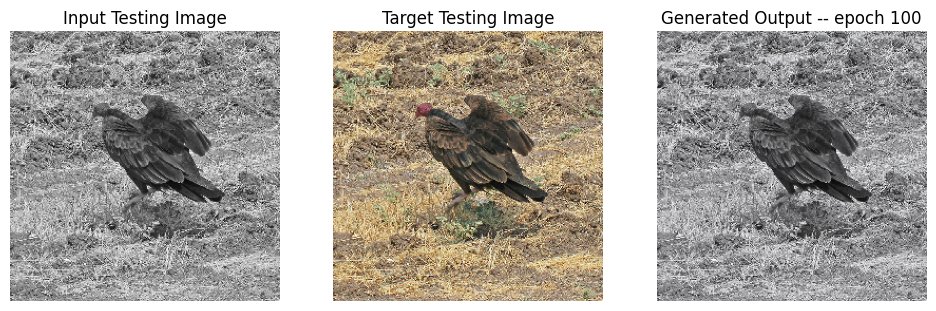

SSIM Score: 0.9655353426933289
PSNR Score: 20.76028060913086


In [44]:
display_random_test_image(gen, '/kaggle/input/imagenet/imagenet/val/ILSVRC2012_val_00000025.JPEG',100)

In [45]:
os.mkdir('/kaggle/working/modelsFeb10')

In [46]:
import random

each_epoch_train_generator_losses = []
each_epoch_train_generator_gan_losses = []
each_epoch_train_generator_l1_losses = []
each_epoch_train_generator_l2_losses = []
each_epoch_train_generator_perceptual_losses = []
each_epoch_train_discriminator_losses = []
each_epoch_train_discriminator_real_losses = []
each_epoch_train_discriminator_generated_losses = []
each_epoch_train_ssim = []
each_epoch_train_psnr = []
each_epoch_train_lpips = []
each_epoch_test_lpips = []
each_epoch_test_psnr = []
each_epoch_test_ssim = []
each_epoch_test_generator_losses = []
each_epoch_test_generator_gan_losses = []
each_epoch_test_generator_l1_losses = []
each_epoch_test_generator_l2_losses = []
each_epoch_test_generator_perceptual_losses = []
each_epoch_test_discriminator_losses = []
each_epoch_test_discriminator_real_losses = []
each_epoch_test_discriminator_generated_losses = []
train_generator_losses = []
train_generator_gan_losses = []
train_generator_l1_losses = []
train_generator_l2_losses = []
train_generator_perceptual_losses = []
train_discriminator_losses = []
train_discriminator_real_losses = []
train_discriminator_generated_losses = []
test_generator_losses = []
test_generator_gan_losses = []
test_generator_l1_losses = []
test_generator_l2_losses = []
test_generator_perceptual_losses = []
test_discriminator_losses = []
test_discriminator_real_losses = []
test_discriminator_generated_losses =[]
training_ssim = []
training_psnr = []
training_lpips = []
testing_ssim = []
testing_psnr = []
testing_lpips = []
each_epoch_all_records = []
all_records = []
def fit(train_ds, epochs, test_ds, gen_model):

    # Declare global lists
    global each_epoch_train_generator_losses, each_epoch_train_generator_gan_losses, each_epoch_train_generator_l1_losses, each_epoch_train_generator_l2_losses, each_epoch_train_generator_perceptual_losses, each_epoch_train_discriminator_losses,each_epoch_train_discriminator_real_losses, each_epoch_train_discriminator_generated_losses, each_epoch_train_ssim, each_epoch_train_psnr
    global each_epoch_test_psnr, each_epoch_test_ssim, each_epoch_test_generator_losses, each_epoch_test_generator_gan_losses, each_epoch_test_generator_l1_losses, each_epoch_test_generator_l2_losses, each_epoch_test_generator_perceptual_losses, each_epoch_test_discriminator_losses, each_epoch_test_discriminator_real_losses, each_epoch_test_discriminator_generated_losses
    global train_generator_losses, train_generator_gan_losses, train_generator_l1_losses, train_generator_l2_losses, train_generator_perceptual_losses, train_discriminator_losses, train_discriminator_real_losses, train_discriminator_generated_losses, test_generator_losses, test_generator_l2_losses, test_generator_gan_losses, test_generator_l1_losses, test_generator_perceptual_losses, test_discriminator_losses, test_discriminator_real_losses, test_discriminator_generated_losses
    global training_ssim, training_psnr, testing_ssim, testing_psnr, each_epoch_all_records, all_records, LAMBDA, each_epoch_train_lpips, each_epoch_test_lpips, training_lpips, testing_lpips


    # Initialize counters and flags
    consecutive_epochs_high_loss = 0
    training_discriminator = True
    stop_training = False
    min_learning_rate = 1e-7  # Set your desired minimum learning rate
    time_start = time.time()
    
    for epoch in range(epochs):
        start = time.time()
        train_count = 0
        test_count = 0

        print(f"Epoch {epoch}")

        for n, (input_, target) in train_ds.enumerate():
            if epoch > 10:
                train_gen_loss, train_gen_gan_loss, train_gen_l1_loss,train_gen_perceptual_loss, train_disc_loss, train_disc_real_loss, train_disc_generated_loss, train_ssim, train_psnr, train_lpips = train_step(input_, target, epoch, training_discriminator=training_discriminator)

            else:
                # If epoch is less than or equal to 10, train both generator and discriminator
                train_gen_loss, train_gen_gan_loss, train_gen_l1_loss, train_gen_perceptual_loss, train_disc_loss, train_disc_real_loss, train_disc_generated_loss, train_ssim, train_psnr, train_lpips  = train_step(input_, target, epoch, training_discriminator=None)

            each_epoch_train_generator_losses.append(train_gen_loss)
            each_epoch_train_generator_gan_losses.append(train_gen_gan_loss)
            each_epoch_train_generator_l1_losses.append(train_gen_l1_loss)
#             each_epoch_train_generator_l2_losses.append(train_gen_l2_loss)
            each_epoch_train_generator_perceptual_losses.append(train_gen_perceptual_loss)
            each_epoch_train_discriminator_losses.append(train_disc_loss)
            each_epoch_train_discriminator_real_losses.append(train_disc_real_loss)
            each_epoch_train_discriminator_generated_losses.append(train_disc_generated_loss)
            each_epoch_train_ssim.append(tf.reduce_mean(train_ssim.numpy()))
            each_epoch_train_psnr.append(tf.reduce_mean(train_psnr.numpy()))
            each_epoch_train_lpips.append(tf.reduce_mean(train_lpips.numpy()))
#             print(train_count)
            train_count += 1
#             print(n)
        #each_epoch_train_generator_losses = np.array(each_epoch_train_generator_losses)
        #print(each_epoch_train_discriminator_losses.shape())
        #print(each_epoch_train_generator_losses.shape())
        #print(each_epoch_train_ssim())
        print("Training Details")
        print("Generator-- total_loss:{:.5f} gan_loss:{:.5f} l1_loss:{:.5f} perceptual_loss:{:.5f} Discriminator-- total_loss:{:.5f} real_loss:{:.5f} generated_loss:{:.5f} --- SSIM {:.5f} PSNR {:.5f} LPIPS {:.5f}".format(np.mean(each_epoch_train_generator_losses),np.mean(each_epoch_train_generator_gan_losses), np.mean(each_epoch_train_generator_l1_losses),np.mean(each_epoch_train_generator_perceptual_losses), np.mean(each_epoch_train_discriminator_losses), np.mean(each_epoch_train_discriminator_generated_losses), np.mean(each_epoch_train_discriminator_real_losses), np.mean(each_epoch_train_ssim), np.mean(each_epoch_train_psnr), np.mean(each_epoch_train_lpips)))
        print("Time taken for epoch {} is {} sec".format(epoch + 1, time.time() - start))
        print(f"Number of iteration {train_count}")

        train_generator_losses.append(np.mean(each_epoch_train_generator_losses))
        train_generator_gan_losses.append(np.mean(each_epoch_train_generator_gan_losses))
        train_generator_l1_losses.append(np.mean(each_epoch_train_generator_l1_losses))
#         train_generator_l2_losses.append(np.mean(each_epoch_train_generator_l2_losses))
        train_generator_perceptual_losses.append(np.mean(each_epoch_train_generator_perceptual_losses))
        train_discriminator_losses.append(np.mean(each_epoch_train_discriminator_losses))
        train_discriminator_real_losses.append(np.mean(each_epoch_train_discriminator_real_losses))
        train_discriminator_generated_losses.append(np.mean(each_epoch_train_discriminator_generated_losses))
        training_ssim.append(np.mean(each_epoch_train_ssim))
        training_psnr.append(np.mean(each_epoch_train_psnr))
        training_lpips.append(np.mean(each_epoch_train_lpips))

        # Test
        for n, (input_, target) in test_ds.enumerate():
            test_gen_loss, test_gen_gan_loss, test_gen_l1_loss, test_gen_perceptual_loss, test_disc_loss, test_disc_real_loss, test_disc_generated_loss, test_ssim, test_psnr, test_lpips = validation_step(input_, target)
            test_count += 1

            each_epoch_test_generator_losses.append(test_gen_loss)
            each_epoch_test_generator_gan_losses.append(test_gen_gan_loss)
            each_epoch_test_generator_l1_losses.append(test_gen_l1_loss)
#             each_epoch_test_generator_l2_losses.append(test_gen_l2_loss)
            each_epoch_test_generator_perceptual_losses.append(test_gen_perceptual_loss)
            each_epoch_test_discriminator_losses.append(test_disc_loss)
            each_epoch_test_discriminator_real_losses.append(test_disc_real_loss)
            each_epoch_test_discriminator_generated_losses.append(test_disc_generated_loss)
            each_epoch_test_ssim.append(tf.reduce_mean(test_ssim.numpy()))
            each_epoch_test_psnr.append(tf.reduce_mean(test_psnr.numpy()))
            each_epoch_test_lpips.append(tf.reduce_mean(test_lpips.numpy()))
    
        print("Validation Details")
        print("Generator-- total_loss:{:.5f} gan_loss:{:.5f} l1_loss:{:.5f}  perceptual_loss:{:.5f} Discriminator-- total_loss:{:.5f} real_loss:{:.5f} generated_loss:{:.5f} --- SSIM {:.5f} PSNR {:.5f} LPIPS {:.5f}".format(np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses), np.mean(each_epoch_test_generator_perceptual_losses),np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses), np.mean(each_epoch_test_ssim), np.mean(each_epoch_test_psnr), np.mean(each_epoch_test_lpips)))
        print("Time taken for epoch {} is {} sec".format(epoch+1, time.time() - start))
        print(f"Number of iteration {test_count}")
#         LAMBDA = LAMBDA * 1.006
        test_generator_losses.append(np.mean(each_epoch_test_generator_losses))
        test_generator_gan_losses.append(np.mean(each_epoch_test_generator_gan_losses))
        test_generator_l1_losses.append(np.mean(each_epoch_test_generator_l1_losses))
#         test_generator_l2_losses.append(np.mean(each_epoch_test_generator_l2_losses))
        test_generator_perceptual_losses.append(np.mean(each_epoch_test_generator_perceptual_losses))
        test_discriminator_losses.append(np.mean(each_epoch_test_discriminator_losses))
        test_discriminator_real_losses.append(np.mean(each_epoch_test_discriminator_real_losses))
        test_discriminator_generated_losses.append(np.mean(each_epoch_test_discriminator_generated_losses))
        testing_ssim.append(np.mean(each_epoch_test_ssim))
        testing_psnr.append(np.mean(each_epoch_test_psnr))
        testing_lpips.append(np.mean(each_epoch_test_lpips))

        each_epoch_all_records.append([np.mean(each_epoch_train_generator_losses),np.mean(each_epoch_train_generator_gan_losses), np.mean(each_epoch_train_generator_l1_losses),np.mean(each_epoch_train_generator_perceptual_losses), np.mean(each_epoch_train_discriminator_losses), np.mean(each_epoch_train_discriminator_generated_losses), np.mean(each_epoch_train_discriminator_real_losses), np.mean(each_epoch_train_ssim), np.mean(each_epoch_train_psnr), np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses),np.mean(each_epoch_test_generator_perceptual_losses),np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses), np.mean(each_epoch_test_ssim), np.mean(each_epoch_test_psnr)])
        all_records.append(each_epoch_all_records)
        # emptying for next epoch
        each_epoch_test_ssim = []
        each_epoch_test_generator_losses = []
        each_epoch_test_generator_gan_losses = []
        each_epoch_test_generator_l1_losses = []
#         each_epoch_test_generator_l2_losses = []
        each_epoch_test_generator_perceptual_losses = []
        each_epoch_test_discriminator_losses = []
        each_epoch_test_discriminator_real_losses = []
        each_epoch_test_discriminator_generated_losses = []
        each_epoch_test_psnr = []
        each_epoch_test_lpips = []
        each_epoch_all_records = []
        #emptyling list for next iteration
        each_epoch_train_generator_losses = []
        each_epoch_train_generator_gan_losses = []
        each_epoch_train_generator_l1_losses = []
#         each_epoch_train_generator_l2_losses = []
        each_epoch_train_generator_perceptual_losses = []
        each_epoch_train_discriminator_losses = []
        each_epoch_train_discriminator_real_losses = []
        each_epoch_train_discriminator_generated_losses = []
        each_epoch_train_ssim = []
        each_epoch_train_psnr = []
        each_epoch_train_lpips = []
        if time.time() - time_start > 30000:
            gen.save(f'/kaggle/working/modelsFeb7/gen_imagenet_{epoch}.h5')
            gen.save_weights(f'/kaggle/working/modelsFeb7/gen_weight_imagenet_{epoch}.keras')
            disc.save(f'/kaggle/working/modelsFeb7/disc_imagenet_{epoch}.h5')
            disc.save_weights(f'/kaggle/working/modelsFeb7/disc_weight_imagenet_{epoch}.keras')
            if 2*(time.time()- start) > 43000- (time.time()-time_start):
                stop_training = True
        if epoch == 0 or epoch % 3 == 0:
            # Function to display one random test image
            # def display_random_test_image(images, labels, gen_model):
            #     # Randomly select an index
            #     random_test_image_idx = random.randint(0, len(images) - 1)

            #     # Extract input and target from the selected index
            #     random_test_input = images[random_test_image_idx]
            #     random_test_target = labels[random_test_image_idx]

            #     # Display the image
            #     display_one_random_test_image(random_test_input, random_test_target, gen_model)

            # Example usage
            display_random_test_image(gen, '/kaggle/input/imagenet/imagenet/val/ILSVRC2012_val_00000030.JPEG', epoch+1)
        # Check if the difference between two consecutive epochs for the last 5 epochs is less than 1
        if epoch > 10:
            # Check 1f the difference between two consecutive epochs for the last S epochs is less than 1 or 0.3
            last_epochs_losses = train_discriminator_losses[-5:] if training_discriminator else train_generator_losses[-5:]
            if all(((last_epochs_losses[i] - last_epochs_losses[i - 1])) < 0.01 if training_discriminator else ((last_epochs_losses[1] - last_epochs_losses[i - 1])) < 0.05 for i in range(1, 5)):
                consecutive_epochs_high_loss += 1
            else:
                consecutive_epochs_high_loss = 0
        
        
#         LAMBDA = LAMBDA*1.003
            # If the condition is met for 4 consecutive epochs, reduce the learning rate
        if consecutive_epochs_high_loss == 4:
            if training_discriminator:
                current_lr = generator_optimizer. learning_rate.numpy()
                new_lr = max (current_lr * 0.45, min_learning_rate)
                if new_lr > min_learning_rate:
                    generator_optimizer.learning_rate.assign(new_lr)
                    print (f"Reduced generator learning rate to {new_lr} at epoch {epoch + 1}")
                    # Switch training focus
                    training_discriminator = not training_discriminator
                else:
                    print(f"Generator learning rate already at the minimum. Stopping training.")
                    stop_training = True
            else:
                current_lr = discriminator_optimizer.learning_rate.numpy()
                new_lr = max (current_lr * 0.3, min_learning_rate)
                if new_lr > min_learning_rate:
                    discriminator_optimizer.learning_rate.assign(new_lr)
                    print(f"Reduced discriminator learning rate to {new_lr} at epoch {epoch + 1}.")
                    # Switch training focus
                    training_discriminator = not training_discriminator
                else:
                    print(f"Discriminator learning rate already at the minimum. Stopping training.")
                    stop_training = True

                consecutive_epochs_high_loss = 0
        # Check the flag variable
        if stop_training:
            break

In [47]:
tf.config.run_functions_eagerly(True)

Epoch 0
Training Details
Generator-- total_loss:9.20075 gan_loss:1.81329 l1_loss:0.05277 perceptual_loss:0.00000 Discriminator-- total_loss:1.02226 real_loss:0.49652 generated_loss:0.52575 --- SSIM 0.85804 PSNR 20.75881 LPIPS 0.00000
Time taken for epoch 1 is 1389.7079753875732 sec
Number of iteration 1407
Validation Details
Generator-- total_loss:9.29743 gan_loss:1.17146 l1_loss:0.05804  perceptual_loss:0.00000 Discriminator-- total_loss:1.68870 real_loss:0.60849 generated_loss:1.08021 --- SSIM 0.88530 PSNR 20.60510 LPIPS 0.00000
Time taken for epoch 1 is 1427.193520307541 sec
Number of iteration 157
Displaying one random test image...


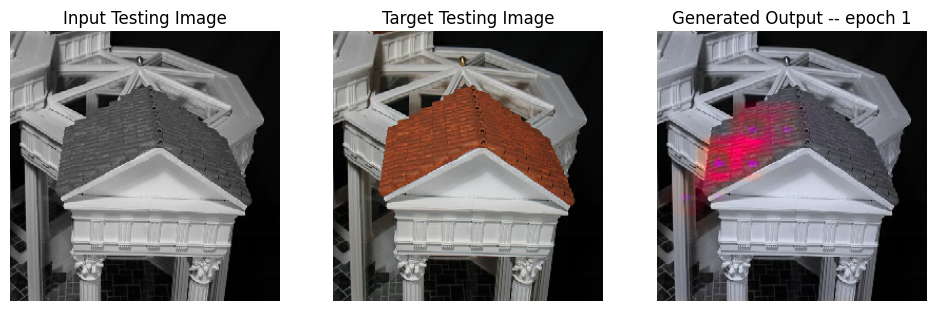

SSIM Score: 0.93266361951828
PSNR Score: 23.525493621826172
Epoch 1
Training Details
Generator-- total_loss:8.52386 gan_loss:1.18534 l1_loss:0.05242 perceptual_loss:0.00000 Discriminator-- total_loss:1.25347 real_loss:0.61192 generated_loss:0.64155 --- SSIM 0.88400 PSNR 21.06225 LPIPS 0.00000
Time taken for epoch 2 is 1382.7618856430054 sec
Number of iteration 1407
Validation Details
Generator-- total_loss:12.52035 gan_loss:0.44537 l1_loss:0.08625  perceptual_loss:0.00000 Discriminator-- total_loss:1.77350 real_loss:1.24642 generated_loss:0.52709 --- SSIM 0.79282 PSNR 15.74392 LPIPS 0.00000
Time taken for epoch 2 is 1420.7237491607666 sec
Number of iteration 157
Epoch 2
Training Details
Generator-- total_loss:8.45802 gan_loss:1.10237 l1_loss:0.05254 perceptual_loss:0.00000 Discriminator-- total_loss:1.22033 real_loss:0.59501 generated_loss:0.62533 --- SSIM 0.87962 PSNR 20.99781 LPIPS 0.00000
Time taken for epoch 3 is 1383.9824075698853 sec
Number of iteration 1407
Validation Details
Ge

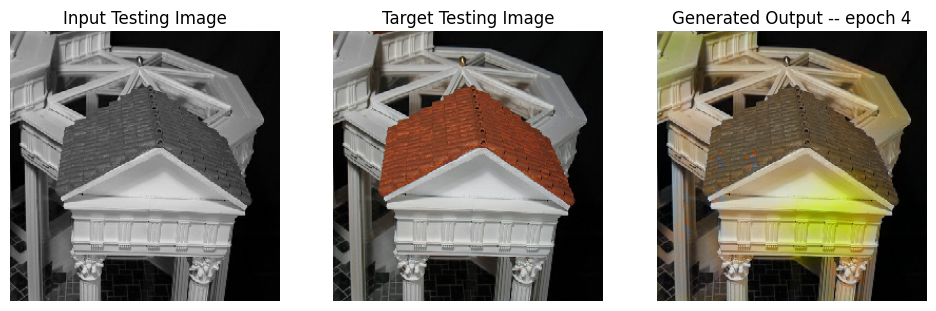

SSIM Score: 0.9290878772735596
PSNR Score: 20.033926010131836
Epoch 4
Training Details
Generator-- total_loss:8.51901 gan_loss:1.09279 l1_loss:0.05304 perceptual_loss:0.00000 Discriminator-- total_loss:1.22210 real_loss:0.59094 generated_loss:0.63115 --- SSIM 0.88142 PSNR 20.99382 LPIPS 0.00000
Time taken for epoch 5 is 1380.7710118293762 sec
Number of iteration 1407
Validation Details
Generator-- total_loss:11.66211 gan_loss:1.42862 l1_loss:0.07310  perceptual_loss:0.00000 Discriminator-- total_loss:1.09405 real_loss:0.43303 generated_loss:0.66102 --- SSIM 0.74860 PSNR 18.02562 LPIPS 0.00000
Time taken for epoch 5 is 1418.5240640640259 sec
Number of iteration 157
Epoch 5
Training Details
Generator-- total_loss:8.52197 gan_loss:1.09151 l1_loss:0.05307 perceptual_loss:0.00000 Discriminator-- total_loss:1.21548 real_loss:0.58684 generated_loss:0.62864 --- SSIM 0.87799 PSNR 20.97618 LPIPS 0.00000
Time taken for epoch 6 is 1383.9885239601135 sec
Number of iteration 1407
Validation Details


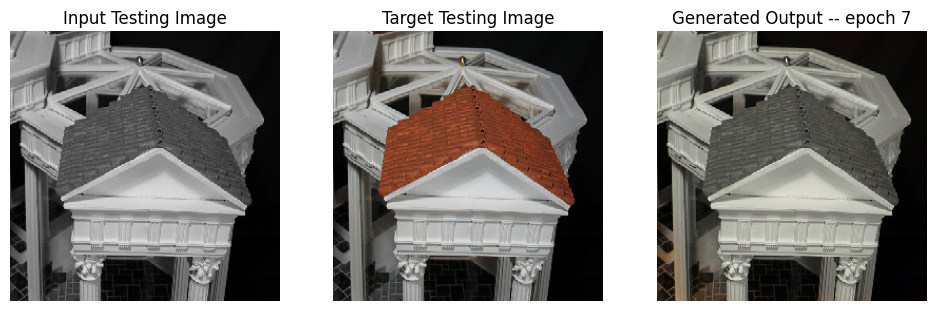

SSIM Score: 0.9516394734382629
PSNR Score: 24.468482971191406
Epoch 7
Training Details
Generator-- total_loss:8.53154 gan_loss:1.09819 l1_loss:0.05310 perceptual_loss:0.00000 Discriminator-- total_loss:1.19221 real_loss:0.57532 generated_loss:0.61688 --- SSIM 0.87705 PSNR 20.95667 LPIPS 0.00000
Time taken for epoch 8 is 1384.6347124576569 sec
Number of iteration 1407
Validation Details
Generator-- total_loss:11.30017 gan_loss:0.57312 l1_loss:0.07662  perceptual_loss:0.00000 Discriminator-- total_loss:1.65848 real_loss:1.07724 generated_loss:0.58123 --- SSIM 0.83329 PSNR 18.08951 LPIPS 0.00000
Time taken for epoch 8 is 1422.745266199112 sec
Number of iteration 157
Epoch 8
Training Details
Generator-- total_loss:8.53004 gan_loss:1.10963 l1_loss:0.05300 perceptual_loss:0.00000 Discriminator-- total_loss:1.19882 real_loss:0.57808 generated_loss:0.62074 --- SSIM 0.87829 PSNR 20.95638 LPIPS 0.00000
Time taken for epoch 9 is 1382.6081926822662 sec
Number of iteration 1407
Validation Details
G

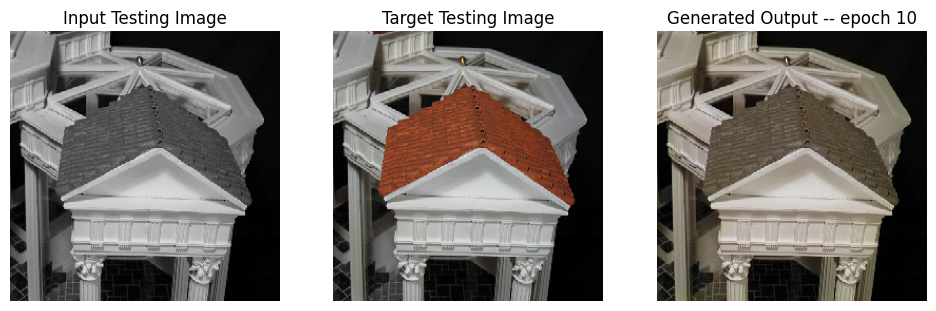

SSIM Score: 0.9556987285614014
PSNR Score: 25.717004776000977
Epoch 10
Training Details
Generator-- total_loss:6.84648 gan_loss:0.56776 l1_loss:0.04485 perceptual_loss:0.00000 Discriminator-- total_loss:1.58462 real_loss:1.06511 generated_loss:0.51951 --- SSIM 0.90051 PSNR 22.89888 LPIPS 0.00000
Time taken for epoch 11 is 850.2569613456726 sec
Number of iteration 1407
Validation Details
Generator-- total_loss:7.81617 gan_loss:0.43914 l1_loss:0.05269  perceptual_loss:0.00000 Discriminator-- total_loss:1.85673 real_loss:1.24952 generated_loss:0.60722 --- SSIM 0.89222 PSNR 21.29371 LPIPS 0.00000
Time taken for epoch 11 is 888.1374139785767 sec
Number of iteration 157
Epoch 11
Training Details
Generator-- total_loss:17.00031 gan_loss:10.65310 l1_loss:0.04534 perceptual_loss:0.00000 Discriminator-- total_loss:0.00397 real_loss:0.00186 generated_loss:0.00211 --- SSIM 0.89737 PSNR 22.88204 LPIPS 0.00000
Time taken for epoch 12 is 907.2708508968353 sec
Number of iteration 1407
Validation Detai

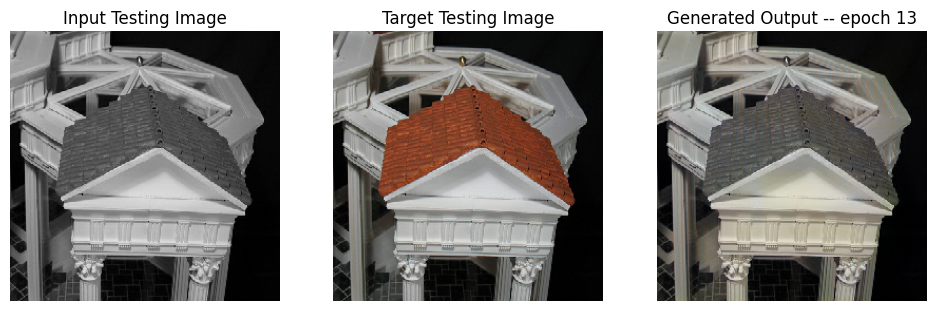

SSIM Score: 0.9434663653373718
PSNR Score: 24.244853973388672
Epoch 13
Training Details
Generator-- total_loss:21.44655 gan_loss:15.10242 l1_loss:0.04532 perceptual_loss:0.00000 Discriminator-- total_loss:0.00001 real_loss:0.00000 generated_loss:0.00001 --- SSIM 0.89735 PSNR 22.88380 LPIPS 0.00000
Time taken for epoch 14 is 908.7284820079803 sec
Number of iteration 1407
Validation Details
Generator-- total_loss:11.55601 gan_loss:4.20766 l1_loss:0.05249  perceptual_loss:0.00000 Discriminator-- total_loss:1.58797 real_loss:0.28223 generated_loss:1.30574 --- SSIM 0.89194 PSNR 22.37780 LPIPS 0.00000
Time taken for epoch 14 is 946.9009099006653 sec
Number of iteration 157
Epoch 14
Training Details
Generator-- total_loss:18.50946 gan_loss:12.16236 l1_loss:0.04534 perceptual_loss:0.00000 Discriminator-- total_loss:0.19582 real_loss:0.09760 generated_loss:0.09822 --- SSIM 0.89735 PSNR 22.87196 LPIPS 0.00000
Time taken for epoch 15 is 909.256751537323 sec
Number of iteration 1407
Validation Det

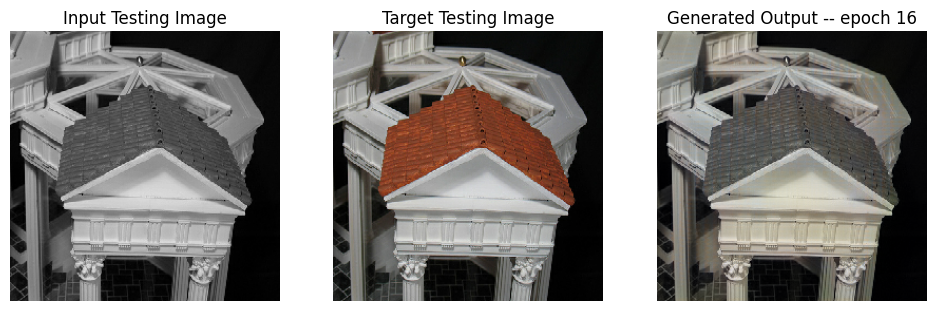

SSIM Score: 0.9433863759040833
PSNR Score: 24.24043846130371
Epoch 16
Training Details
Generator-- total_loss:19.33670 gan_loss:12.98664 l1_loss:0.04536 perceptual_loss:0.00000 Discriminator-- total_loss:0.02821 real_loss:0.02815 generated_loss:0.00006 --- SSIM 0.89732 PSNR 22.87962 LPIPS 0.00000
Time taken for epoch 17 is 909.516942024231 sec
Number of iteration 1407
Validation Details
Generator-- total_loss:21.73500 gan_loss:14.46146 l1_loss:0.05195  perceptual_loss:0.00000 Discriminator-- total_loss:12.94584 real_loss:0.00248 generated_loss:12.94336 --- SSIM 0.89251 PSNR 22.42126 LPIPS 0.00000
Time taken for epoch 17 is 947.6662859916687 sec
Number of iteration 157
Epoch 17
Training Details
Generator-- total_loss:17.33602 gan_loss:10.98954 l1_loss:0.04533 perceptual_loss:0.00000 Discriminator-- total_loss:0.09359 real_loss:0.05222 generated_loss:0.04137 --- SSIM 0.89732 PSNR 22.88463 LPIPS 0.00000
Time taken for epoch 18 is 912.093103647232 sec
Number of iteration 1407
Validation De

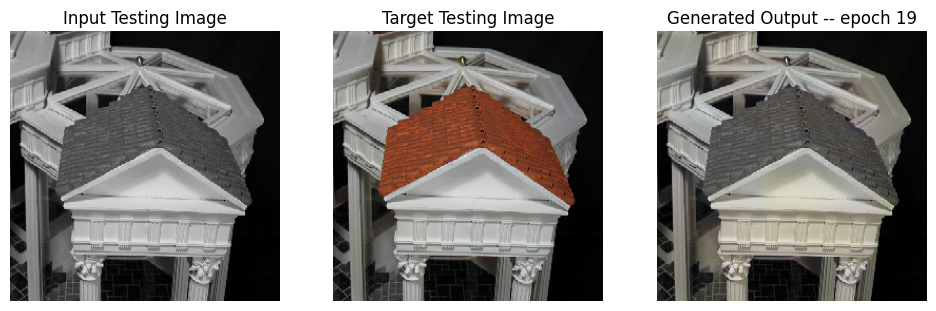

SSIM Score: 0.9432349801063538
PSNR Score: 24.219850540161133
Epoch 19
Training Details
Generator-- total_loss:20.20263 gan_loss:13.85352 l1_loss:0.04535 perceptual_loss:0.00000 Discriminator-- total_loss:0.00004 real_loss:0.00002 generated_loss:0.00002 --- SSIM 0.89735 PSNR 22.87581 LPIPS 0.00000
Time taken for epoch 20 is 909.6641209125519 sec
Number of iteration 1407
Validation Details
Generator-- total_loss:12.66008 gan_loss:5.41448 l1_loss:0.05175  perceptual_loss:0.00000 Discriminator-- total_loss:2.86789 real_loss:0.27415 generated_loss:2.59374 --- SSIM 0.89267 PSNR 22.44403 LPIPS 0.00000
Time taken for epoch 20 is 947.7042980194092 sec
Number of iteration 157
Epoch 20
Training Details
Generator-- total_loss:25.80046 gan_loss:19.45631 l1_loss:0.04532 perceptual_loss:0.00000 Discriminator-- total_loss:0.09318 real_loss:0.04626 generated_loss:0.04692 --- SSIM 0.89740 PSNR 22.88856 LPIPS 0.00000
Time taken for epoch 21 is 910.2054305076599 sec
Number of iteration 1407
Validation De

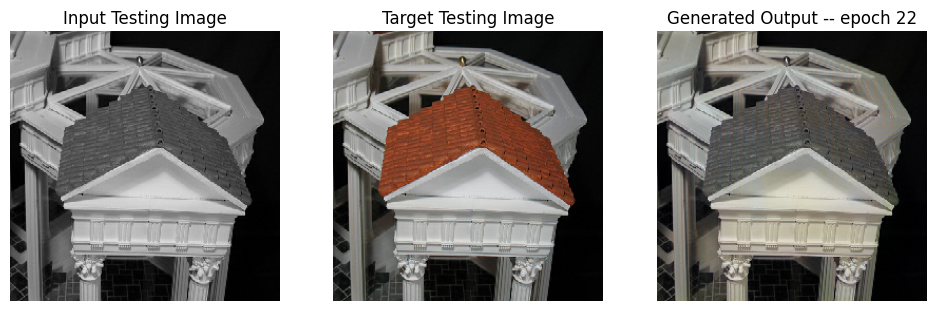

SSIM Score: 0.9433683753013611
PSNR Score: 24.244237899780273
Epoch 22
Training Details
Generator-- total_loss:27.36682 gan_loss:21.02652 l1_loss:0.04529 perceptual_loss:0.00000 Discriminator-- total_loss:0.01002 real_loss:0.00295 generated_loss:0.00707 --- SSIM 0.89752 PSNR 22.89751 LPIPS 0.00000
Time taken for epoch 23 is 909.4381642341614 sec
Number of iteration 1407
Validation Details
Generator-- total_loss:22.35674 gan_loss:14.90760 l1_loss:0.05321  perceptual_loss:0.00000 Discriminator-- total_loss:3.11203 real_loss:0.32198 generated_loss:2.79005 --- SSIM 0.89050 PSNR 22.29670 LPIPS 0.00000
Time taken for epoch 23 is 947.4933066368103 sec
Number of iteration 157
Epoch 23
Training Details
Generator-- total_loss:26.05468 gan_loss:19.71074 l1_loss:0.04531 perceptual_loss:0.00000 Discriminator-- total_loss:0.00007 real_loss:0.00002 generated_loss:0.00005 --- SSIM 0.89742 PSNR 22.88440 LPIPS 0.00000
Time taken for epoch 24 is 908.6461565494537 sec
Number of iteration 1407
Validation D

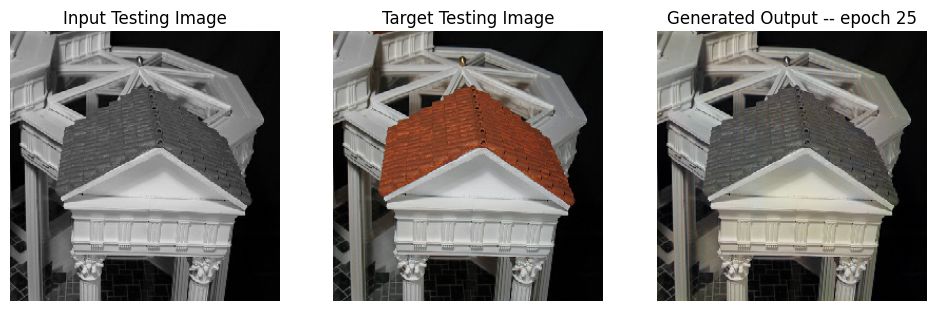

SSIM Score: 0.9432454109191895
PSNR Score: 24.229923248291016
Epoch 25
Training Details
Generator-- total_loss:26.17014 gan_loss:19.82695 l1_loss:0.04531 perceptual_loss:0.00000 Discriminator-- total_loss:0.06823 real_loss:0.00746 generated_loss:0.06077 --- SSIM 0.89735 PSNR 22.88909 LPIPS 0.00000
Time taken for epoch 26 is 907.4498491287231 sec
Number of iteration 1407
Validation Details
Generator-- total_loss:11.61775 gan_loss:4.39070 l1_loss:0.05162  perceptual_loss:0.00000 Discriminator-- total_loss:3.72965 real_loss:0.69974 generated_loss:3.02991 --- SSIM 0.89284 PSNR 22.45576 LPIPS 0.00000
Time taken for epoch 26 is 945.2687509059906 sec
Number of iteration 157
Epoch 26
Training Details
Generator-- total_loss:24.36823 gan_loss:18.02041 l1_loss:0.04534 perceptual_loss:0.00000 Discriminator-- total_loss:0.00005 real_loss:0.00003 generated_loss:0.00002 --- SSIM 0.89731 PSNR 22.88714 LPIPS 0.00000
Time taken for epoch 27 is 906.7777798175812 sec
Number of iteration 1407
Validation De

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Displaying one random test image...


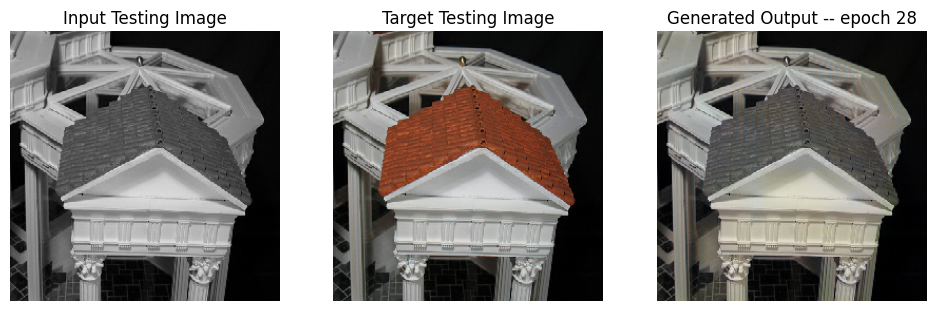

SSIM Score: 0.9433351159095764
PSNR Score: 24.220497131347656
Epoch 28
Training Details
Generator-- total_loss:25.74879 gan_loss:19.39899 l1_loss:0.04536 perceptual_loss:0.00000 Discriminator-- total_loss:0.00002 real_loss:0.00001 generated_loss:0.00001 --- SSIM 0.89733 PSNR 22.88697 LPIPS 0.00000
Time taken for epoch 29 is 906.8051126003265 sec
Number of iteration 1407
Validation Details
Generator-- total_loss:12.41584 gan_loss:5.12244 l1_loss:0.05210  perceptual_loss:0.00000 Discriminator-- total_loss:5.20827 real_loss:0.51382 generated_loss:4.69446 --- SSIM 0.89245 PSNR 22.41260 LPIPS 0.00000
Time taken for epoch 29 is 944.7902083396912 sec
Number of iteration 157
Epoch 29
Training Details
Generator-- total_loss:27.55101 gan_loss:21.20587 l1_loss:0.04532 perceptual_loss:0.00000 Discriminator-- total_loss:0.03468 real_loss:0.03468 generated_loss:0.00000 --- SSIM 0.89749 PSNR 22.89529 LPIPS 0.00000
Time taken for epoch 30 is 904.7522568702698 sec
Number of iteration 1407
Validation De

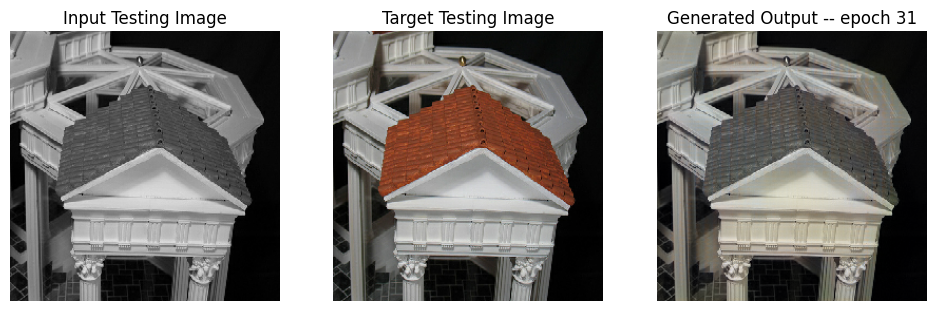

SSIM Score: 0.9433730244636536
PSNR Score: 24.226863861083984
Epoch 31
Training Details
Generator-- total_loss:29.72152 gan_loss:23.37379 l1_loss:0.04534 perceptual_loss:0.00000 Discriminator-- total_loss:0.00007 real_loss:0.00005 generated_loss:0.00003 --- SSIM 0.89733 PSNR 22.88508 LPIPS 0.00000
Time taken for epoch 32 is 908.4147682189941 sec
Number of iteration 1407
Validation Details
Generator-- total_loss:21.89995 gan_loss:14.59837 l1_loss:0.05215  perceptual_loss:0.00000 Discriminator-- total_loss:3.47196 real_loss:1.19316 generated_loss:2.27879 --- SSIM 0.89213 PSNR 22.39745 LPIPS 0.00000
Time taken for epoch 32 is 946.6479721069336 sec
Number of iteration 157
Epoch 32
Training Details
Generator-- total_loss:30.97671 gan_loss:24.62858 l1_loss:0.04534 perceptual_loss:0.00000 Discriminator-- total_loss:0.00004 real_loss:0.00003 generated_loss:0.00002 --- SSIM 0.89737 PSNR 22.88545 LPIPS 0.00000
Time taken for epoch 33 is 905.0672612190247 sec
Number of iteration 1407
Validation D

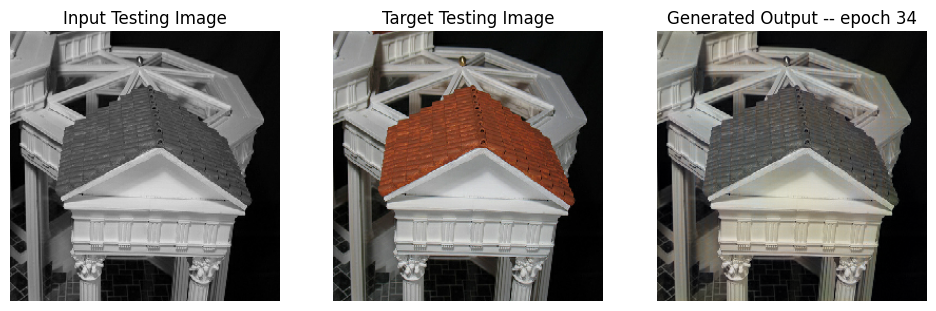

SSIM Score: 0.9430801868438721
PSNR Score: 24.204824447631836
Epoch 34
Training Details
Generator-- total_loss:20.48832 gan_loss:14.14396 l1_loss:0.04532 perceptual_loss:0.00000 Discriminator-- total_loss:0.05649 real_loss:0.02810 generated_loss:0.02839 --- SSIM 0.89748 PSNR 22.88798 LPIPS 0.00000
Time taken for epoch 35 is 906.2553470134735 sec
Number of iteration 1407
Validation Details
Generator-- total_loss:16.96666 gan_loss:9.67015 l1_loss:0.05212  perceptual_loss:0.00000 Discriminator-- total_loss:4.85355 real_loss:0.01421 generated_loss:4.83934 --- SSIM 0.89239 PSNR 22.40545 LPIPS 0.00000
Time taken for epoch 35 is 944.1194756031036 sec
Number of iteration 157
Epoch 35
Training Details
Generator-- total_loss:21.20557 gan_loss:14.85836 l1_loss:0.04534 perceptual_loss:0.00000 Discriminator-- total_loss:0.00008 real_loss:0.00004 generated_loss:0.00004 --- SSIM 0.89734 PSNR 22.87621 LPIPS 0.00000
Time taken for epoch 36 is 907.5235750675201 sec
Number of iteration 1407
Validation De

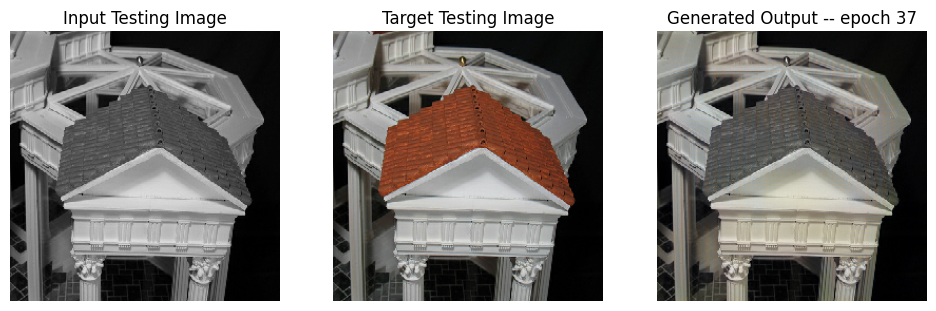

SSIM Score: 0.943342924118042
PSNR Score: 24.22722053527832
Epoch 37
Training Details
Generator-- total_loss:24.07845 gan_loss:17.73283 l1_loss:0.04533 perceptual_loss:0.00000 Discriminator-- total_loss:0.00001 real_loss:0.00000 generated_loss:0.00000 --- SSIM 0.89736 PSNR 22.88454 LPIPS 0.00000
Time taken for epoch 38 is 906.7975180149078 sec
Number of iteration 1407
Validation Details
Generator-- total_loss:18.36640 gan_loss:11.07350 l1_loss:0.05209  perceptual_loss:0.00000 Discriminator-- total_loss:6.68842 real_loss:0.00170 generated_loss:6.68672 --- SSIM 0.89229 PSNR 22.41779 LPIPS 0.00000
Time taken for epoch 38 is 944.6294980049133 sec
Number of iteration 157
Epoch 38
Training Details
Generator-- total_loss:24.67548 gan_loss:18.32692 l1_loss:0.04535 perceptual_loss:0.00000 Discriminator-- total_loss:0.00001 real_loss:0.00000 generated_loss:0.00000 --- SSIM 0.89736 PSNR 22.88834 LPIPS 0.00000
Time taken for epoch 39 is 908.5614895820618 sec
Number of iteration 1407
Validation Det

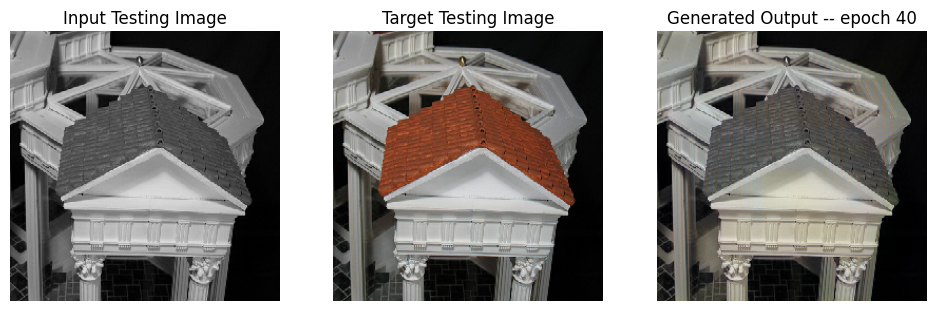

SSIM Score: 0.9431269764900208
PSNR Score: 24.222375869750977


In [48]:
fit(train_dataset, epochs, validation_dataset, gen)

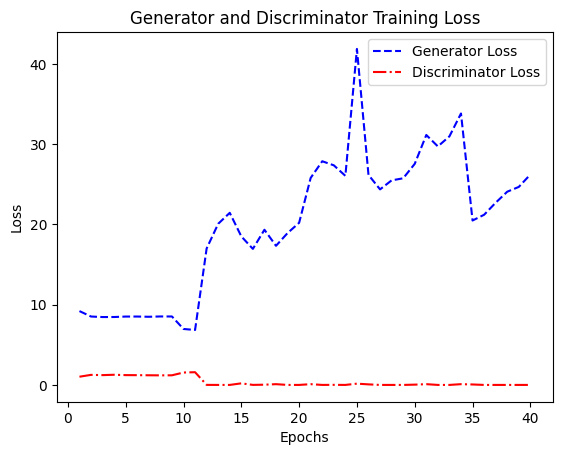

In [49]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_losses, '--b', label='Generator Loss')
plt.plot(epochs, train_discriminator_losses, '-.r', label='Discriminator Loss')
plt.title('Generator and Discriminator Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/train_loss_plot_1.png')
plt.show()

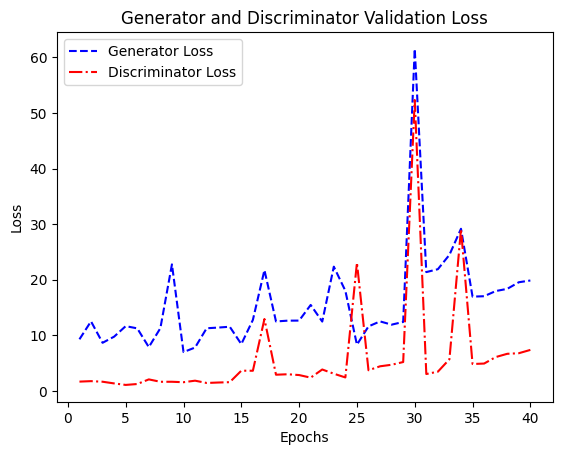

In [50]:
epochs = range(1, len(test_generator_losses) + 1)

plt.plot(epochs, test_generator_losses, '--b', label='Generator Loss')
plt.plot(epochs, test_discriminator_losses, '-.r', label='Discriminator Loss')
plt.title('Generator and Discriminator Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/test_loss_plot_1.png')
plt.show()

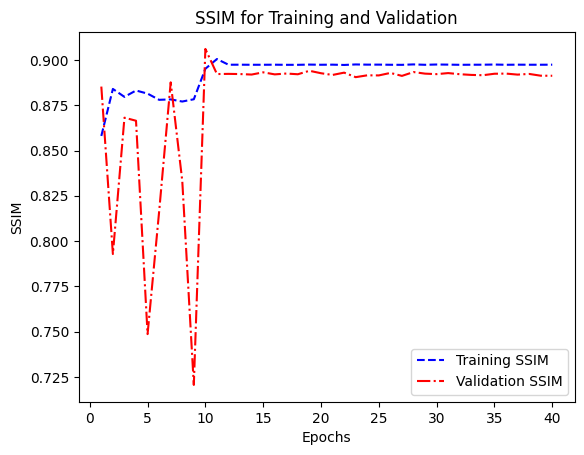

In [51]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, training_ssim, '--b', label='Training SSIM')
plt.plot(epochs, testing_ssim, '-.r', label='Validation SSIM')
plt.title('SSIM for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.legend()
plt.savefig('/kaggle/working/SSIM_plot_1.png')
plt.show()

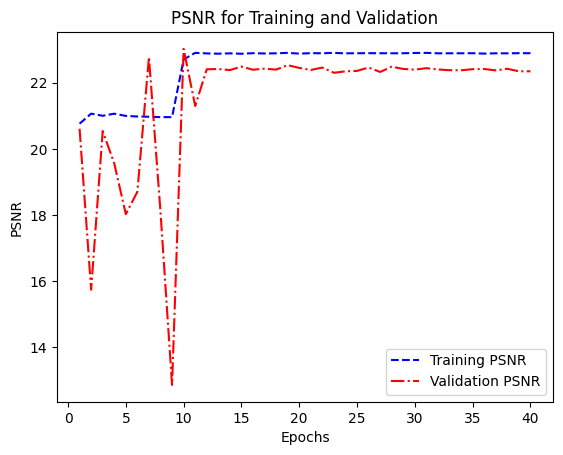

In [52]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, training_psnr, '--b', label='Training PSNR')
plt.plot(epochs, testing_psnr, '-.r', label='Validation PSNR')
plt.title('PSNR for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()
plt.savefig('/kaggle/working/PSNR_plot_1.png')
plt.show()

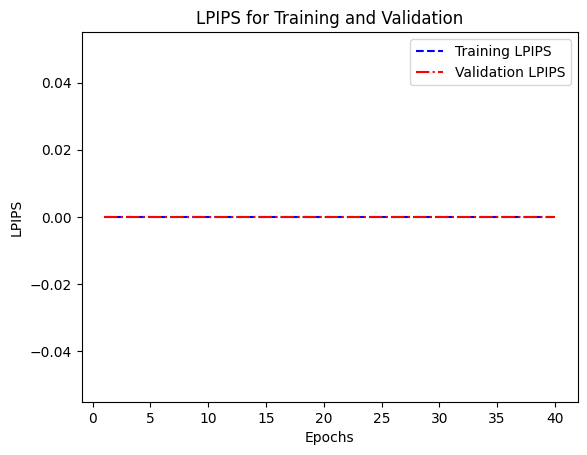

In [53]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, training_lpips, '--b', label='Training LPIPS')
plt.plot(epochs, testing_lpips, '-.r', label='Validation LPIPS')
plt.title('LPIPS for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('LPIPS')
plt.legend()
plt.savefig('/kaggle/working/LPIPS_plot_1.png')
plt.show()

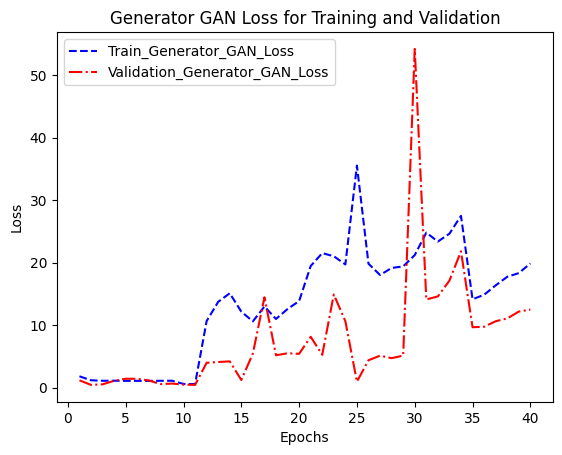

In [54]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_gan_losses, '--b', label='Train_Generator_GAN_Loss')
plt.plot(epochs, test_generator_gan_losses, '-.r', label='Validation_Generator_GAN_Loss')
plt.title('Generator GAN Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_GAN_plot_1.png')
plt.show()

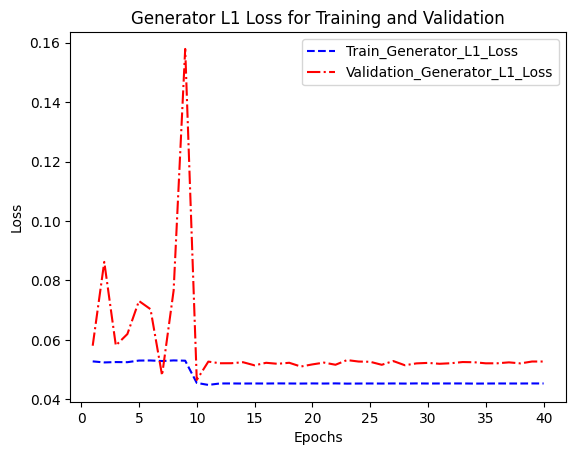

In [55]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_l1_losses, '--b', label='Train_Generator_L1_Loss')
plt.plot(epochs, test_generator_l1_losses, '-.r', label='Validation_Generator_L1_Loss')
plt.title('Generator L1 Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_L1_plot_1.png')
plt.show()

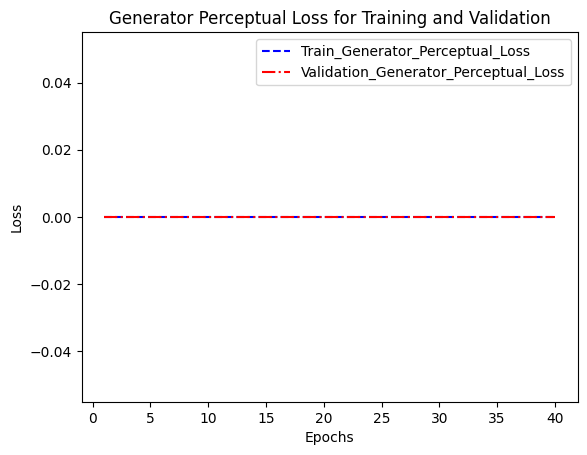

In [56]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_perceptual_losses, '--b', label='Train_Generator_Perceptual_Loss')
plt.plot(epochs, test_generator_perceptual_losses, '-.r', label='Validation_Generator_Perceptual_Loss')
plt.title('Generator Perceptual Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_Perceptual_plot_1.png')
plt.show()

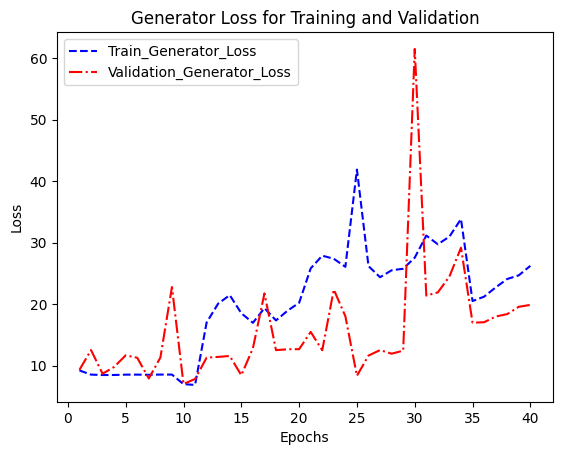

In [57]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_losses, '--b', label='Train_Generator_Loss')
plt.plot(epochs, test_generator_losses, '-.r', label='Validation_Generator_Loss')
plt.title('Generator Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_plot_1.png')
plt.show()

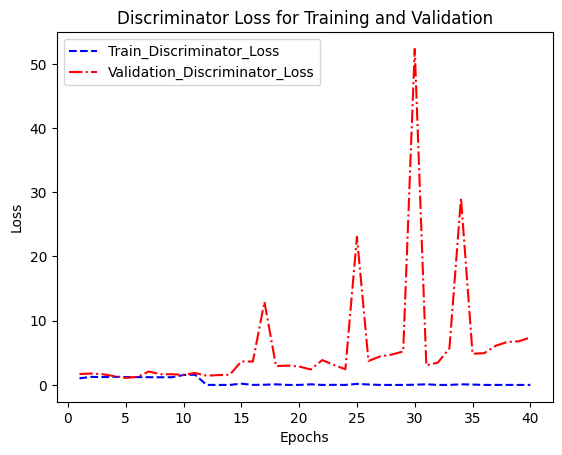

In [58]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_losses, '--b', label='Train_Discriminator_Loss')
plt.plot(epochs, test_discriminator_losses, '-.r', label='Validation_Discriminator_Loss')
plt.title('Discriminator Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_plot_1.png')
plt.show()

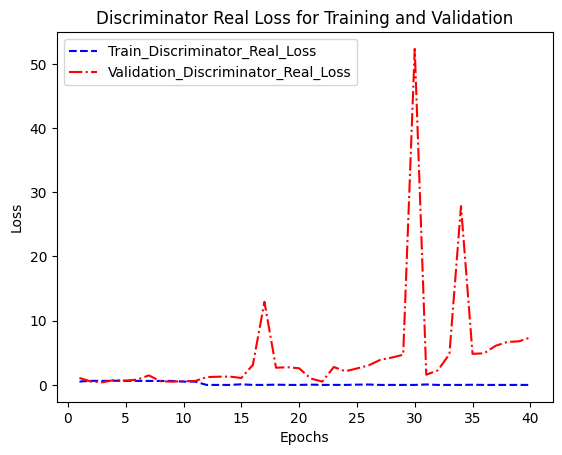

In [59]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_real_losses, '--b', label='Train_Discriminator_Real_Loss')
plt.plot(epochs, test_discriminator_real_losses, '-.r', label='Validation_Discriminator_Real_Loss')
plt.title('Discriminator Real Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_Real_plot_1.png')
plt.show()

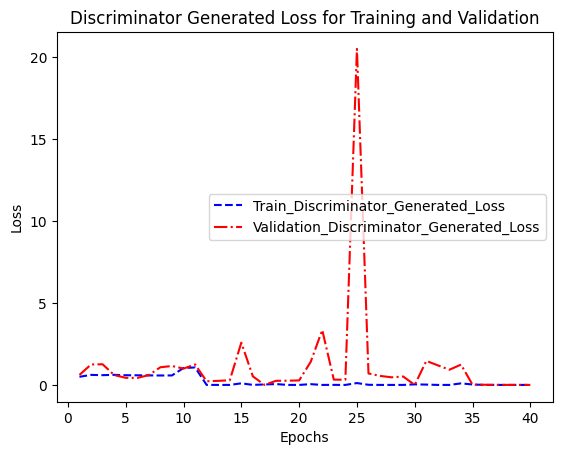

In [60]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_generated_losses, '--b', label='Train_Discriminator_Generated_Loss')
plt.plot(epochs, test_discriminator_generated_losses, '-.r', label='Validation_Discriminator_Generated_Loss')
plt.title('Discriminator Generated Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_Generated_plot_1.png')
plt.show()

In [61]:
import csv
with open('/kaggle/working/dataJan20.csv','w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(all_records)

In [62]:
# # Evaluation on testing data


# each_epoch_test_lpips = []
# each_epoch_test_psnr = []
# each_epoch_test_ssim = []
# each_epoch_test_fid = []
# each_epoch_test_generator_losses = []
# each_epoch_test_generator_gan_losses = []
# each_epoch_test_generator_l1_losses = []
# each_epoch_test_generator_l2_losses = []
# each_epoch_test_generator_perceptual_losses = []
# each_epoch_test_discriminator_losses = []
# each_epoch_test_discriminator_real_losses = []
# each_epoch_test_discriminator_generated_losses = []

# for n, (input_, target) in test_dataset.enumerate():
#     test_gen_loss, test_gen_gan_loss, test_gen_l1_loss, test_gen_perceptual_loss, test_disc_loss, test_disc_real_loss, test_disc_generated_loss, test_ssim, test_psnr, test_lpips, test_fid = test_step(input_, target)

#     each_epoch_test_generator_losses.append(test_gen_loss)
#     each_epoch_test_generator_gan_losses.append(test_gen_gan_loss)
#     each_epoch_test_generator_l1_losses.append(test_gen_l1_loss)
# #             each_epoch_test_generator_l2_losses.append(test_gen_l2_loss)
#     each_epoch_test_generator_perceptual_losses.append(test_gen_perceptual_loss)
#     each_epoch_test_discriminator_losses.append(test_disc_loss)
#     each_epoch_test_discriminator_real_losses.append(test_disc_real_loss)
#     each_epoch_test_discriminator_generated_losses.append(test_disc_generated_loss)
#     each_epoch_test_ssim.append(tf.reduce_mean(test_ssim.numpy()))
#     each_epoch_test_psnr.append(tf.reduce_mean(test_psnr.numpy()))
#     each_epoch_test_lpips.append(tf.reduce_mean(test_lpips.numpy()))
#     each_epoch_test_fid.append(test_fid)
#     print(test_fid)

# print("Testing Details")
# print("Generator-- total_loss:{:.5f} gan_loss:{:.5f} l1_loss:{:.5f}  perceptual_loss:{:.5f} \nDiscriminator-- total_loss:{:.5f} real_loss:{:.5f} generated_loss:{:.5f} --- \nSSIM {:.5f} \nPSNR {:.5f} \nLPIPS {:.5f} \nFID Score: {:.5f}".format(np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses), np.mean(each_epoch_test_generator_perceptual_losses),np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses), np.mean(each_epoch_test_ssim), np.mean(each_epoch_test_psnr), np.mean(each_epoch_test_lpips), np.mean(each_epoch_test_fid)))

In [63]:
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode !=0:
        print("Unable to run zip command")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [64]:
import subprocess
from IPython.display import FileLink, display

In [65]:
download_file('/kaggle/working', 'outputFeb8')

/kaggle/working/outputFeb8.zip